In [6]:
import pandas as pd
# pd.reset_option("all")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = 2000
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
from sklearn.model_selection import ParameterGrid,cross_val_score

In [7]:
df = pd.read_csv('final_df.csv', index_col = [0])

In [9]:
clf = LogisticRegression(C=10, penalty='l1', solver='liblinear')
feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']
indices = [i for i, x in enumerate(X.columns) if x in ['mean_0','mean_1', 'mean_2']]
outcomes = ["draw    ", "home win", "away win"]

X_train, X_intermediate, y_train, y_intermediate = train_test_split(X, y, test_size=0.35, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_intermediate, y_intermediate, test_size=(0.15/0.35), random_state=1)

print(f"training\f", X_train.shape, y_train.shape)
print(f"validation:\f", X_val.shape, y_val.shape)
print(f"test\f", X_test.shape, y_test.shape)

training (1711, 134) (1711,)
validation: (526, 134) (526,)
test (396, 134) (396,)


In [27]:
grid_search.best_results_

AttributeError: 'GridSearchCV' object has no attribute 'best_results_'

In [28]:
profit_scorer = make_scorer(profit_score, greater_is_better=True, needs_proba=True, mean_index=indices, original_data=X_train)

# Define the logistic regression model
logreg = LogisticRegression()

# Define the parameter grid for the logistic regression model
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Perform grid search on the logistic regression model
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring=profit_scorer)
grid_search.fit(X_val, y_val)

# Print the best parameters found
print(grid_search.best_params_)

# Train the logistic regression model with the best parameters found
best_logreg = LogisticRegression(**grid_search.best_params_)
best_logreg.fit(X_train, y_train)

# Evaluate the model on the test data
test_score = profit_score(y_test, best_logreg.predict_proba(X_test), mean_index=indices, original_data=X_test)
print(f"Profit on test data: {test_score}")


In [4]:
def profit_score(y_true, y_pred_proba, **kwargs):
    mean_index = kwargs.get('mean_index')
    original_data = kwargs.get('original_data')
    alpha = kwargs.get('alpha', np.array([0.057, 0.034, 0.037]))
#     alpha = kwargs.get('alpha', np.array([0.0, 0.0, 0.0]))
    bankroll = kwargs.get('bankroll', 10000)
    kelly_fraction = kwargs.get('kelly_fraction', 0.025)
    outcomes = ["draw    ", "home win", "away win"]

    total_profit = 0
    actual_outcomes = y_true.to_numpy()

    for i in range(len(y_pred_proba)):
        features = original_data.iloc[i]
        odds = np.array([features[mean_index[0]], features[mean_index[1]], features[mean_index[2]]])
        pred_probs = y_pred_proba[i]
        implied_probs = 1 / odds
        diffs = pred_probs - implied_probs
        j = np.argmax(diffs)

        if diffs[j] > alpha[j]:
            bet_fraction = kelly_fraction * (pred_probs[j] * odds[j] - (1 - pred_probs[j])) / (odds[j])
            bet_amount = bet_fraction * bankroll

            if actual_outcomes[i] == j:
                profit = (odds[j] - 1) * bet_amount
            else:
                profit = -bet_amount

            bankroll += profit
            total_profit += profit

#             print(f"bankroll: {bankroll:.1f} - game: {i+1} - outcome: {outcomes[actual_outcomes[i]]} - bet: {outcomes[j]} - pred prob: {pred_probs[j]:.3f} - given prob: {implied_probs[j]:.3f} - odds: {odds[j]:.3f} - bet size: {bet_amount:.3f} - profit/Loss: {profit:.3f}")

    return total_profit

profit_scorer = make_scorer(profit_score, greater_is_better=True, needs_proba=True, mean_index=indices, original_data=X_train)

In [20]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
#     'max_iter': [100,1000,10000,100000]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring=profit_scorer, cv=5, n_jobs=-1, verbose = 10)
grid_search.fit(X_train, y_train)

profit_scorer_test = make_scorer(profit_score, greater_is_better=True, needs_proba=True, mean_index=indices, original_data=X_test)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score on test set: ", profit_scorer_test(grid_search.best_estimator_, X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [2.30083247e+10            nan            nan            nan
 3.55604003e+10 2.63068869e+10 2.45332425e+10 2.21855041e+10
 3.36314286e+10 3.40362497e+10 2.85495949e+10            nan
            nan            nan 3.52451242e+10 2.84199042e+10
 4.45854231e+10 2.59308317e+10 3.37589134e+10 3.40809200e+10
 4.11824967e+10            nan            nan            nan
 3.39698787e+10 4.09434300e+10 4.30336722e+10 1.91825162e+10
 3.52223082e+10 3.40161057e+10 4.01866327e+10            nan
            nan            nan 3.41318077e+10 3.99973616e+10
 4.32693288e+10 2.23424941e+10 3.37386337e+10 3.38391528e+10]
  warnings.warn(


Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score on test set:  -1380.1034602803475


/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [8]:
class TqdmScore:
    def __init__(self, n_splits):
        self.bar = tqdm(total=n_splits)
        
    def __call__(self, estimator, X, y):
        score = accuracy_score(y, estimator.predict(X))
        self.bar.update()
        return score

def select_features(X, y, model):
    feature_sets = {}

    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),
                  scoring='f1',
                  min_features_to_select=25)
    rfecv.fit(X, y)

    selected_features_rfe = [f for f, s in zip(X.columns, rfecv.support_) if s]
    feature_sets['rfe'] = {'features': selected_features_rfe, 'score': rfecv.grid_scores_[-1]}

    mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)
    mi_selector.fit(X, y)

    selected_features_mi = [f for f, s in zip(X.columns, mi_selector.get_support()) if s]
    feature_sets['mutual_info'] = {'features': selected_features_mi, 'score': mi_selector.scores_}

    corr_matrix = X.corr().abs()
    high_corr_vars = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.75)]
    
    selected_features_corr = high_corr_vars
    feature_sets['correlation'] = {'features': selected_features_corr, 'score': np.mean([corr_matrix.loc[f, f] for f in high_corr_vars])}

    return feature_sets

83it [45:21, 32.79s/it]


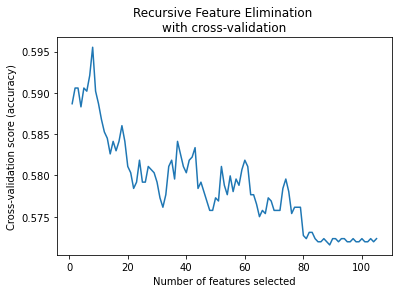

In [15]:
n_scores = len(rfecv.grid_scores_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, n_scores + 1), rfecv.grid_scores_)
plt.title("Recursive Feature Elimination \nwith cross-validation")
plt.show()

In [23]:
def create_nn():
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))  # Assuming a multi-class problem with 3 classes

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

class ProbKerasClassifier(KerasClassifier):
    def predict(self, X, **kwargs):
        """Override the predict method to return class probabilities"""
        return super().predict_proba(X)

neural_net = {
    'model_type': 'Neural Network',
    'model': ProbKerasClassifier(build_fn=create_nn, verbose=0),
    'params': {'epochs': [50, 100, 200], 'batch_size': [10, 50, 100]}
}

In [16]:
model_param_dict_list = [
    {
        'model_type': 'Logistic Regression',
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    },
    {
        'model_type': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [100, 500, 1000], 'max_depth': [5, 10, 20], 'min_samples_leaf': [2, 5, 10]}
    },
    {
        'model_type': 'Support Vector Classifier',
        'model': SVC(probability=True),  # Enable probability estimates. This must be enabled prior to calling fit
        'params': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
    },
    {
        'model_type': 'K-Nearest Neighbors',
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 11], 'weights': ['uniform', 'distance']}
    },
    {
        'model_type': 'Decision Tree',
        'model': DecisionTreeClassifier(),
        'params': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20], 'min_samples_leaf': [2, 5, 10]}
    },
    {
        'model_type': 'Gaussian Naive Bayes',
        'model': GaussianNB(),
        'params': {}  # GaussianNB does not have hyperparameters to tune
    },
]

In [13]:
def optimize_model(X, y, original_data, models, feature_sets, hyperparameters, alpha=np.array([0.057, 0.034, 0.037]), bankroll=10000, kelly_fraction=0.025):
    best_profit = float('-inf')
    best_model = None
    best_features = None
    best_hyperparameters = None

    for model in models:
        for features in feature_sets:
            X_subset = X[features]
            original_data_subset = original_data[features]

            for hyperparams in hyperparameters:
                # train the model with these hyperparameters
                model.set_params(**hyperparams)
                model.fit(X_subset, y)

                # calculate the profit
                profit = profit_score(model, X_subset, y, original_data_subset, alpha, bankroll, kelly_fraction)

                # if this model/feature set/hyperparameters is the best so far, save it
                if profit > best_profit:
                    best_profit = profit
                    best_model = model
                    best_features = features
                    best_hyperparameters = hyperparams

    return best_model, best_features, best_hyperparameters, best_profit

Epoch 1/10
58/58 [==============================] - 0s 6ms/step - loss: 1.0419 - accuracy: 0.4753 - val_loss: 1.0045 - val_accuracy: 0.5835
Epoch 2/10
58/58 [==============================] - 0s 3ms/step - loss: 0.9630 - accuracy: 0.6050 - val_loss: 0.9826 - val_accuracy: 0.5747
Epoch 3/10
58/58 [==============================] - 0s 3ms/step - loss: 0.9080 - accuracy: 0.6375 - val_loss: 0.9559 - val_accuracy: 0.5835
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 0.8418 - accuracy: 0.6636 - val_loss: 0.9143 - val_accuracy: 0.5873
Epoch 5/10
58/58 [==============================] - 0s 3ms/step - loss: 0.7389 - accuracy: 0.6907 - val_loss: 0.9488 - val_accuracy: 0.5506
Epoch 6/10
58/58 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.7417 - val_loss: 0.9749 - val_accuracy: 0.5620
Epoch 7/10
58/58 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.7786 - val_loss: 1.0516 - val_accuracy: 0.5595
Epoch 8/10
58/58 [==

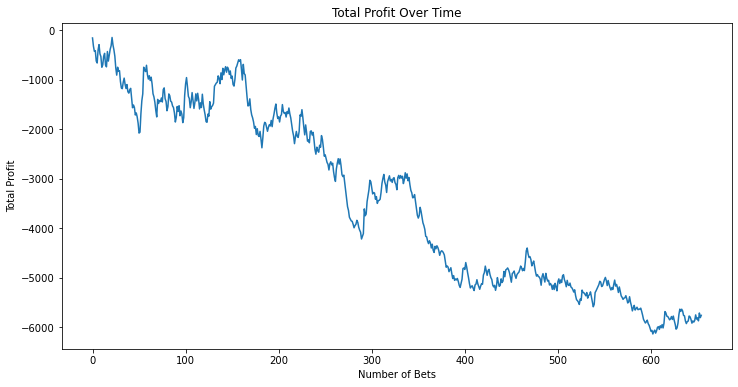

In [7]:
# Bankroll Kelly

feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']

X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train_series.values.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test_series.values.reshape(-1, 1)).toarray()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

def predict_percentages(model, X):
    pred = model.predict(X)
    return pred / 1

predictions = predict_percentages(model, X_test)

profits = []
total_profit = 0
bets_odds = []
bets_count = 0
actual_outcomes = np.argmax(y_test, axis=1)
alpha = np.array([0.057, 0.034, 0.037])
# alpha = np.array([0.,0.,0.])

bankroll = 10000
kelly_fraction = 0.025
outcomes = ["draw    ", "home win", "away win"]

bets_won = []
bets_lost = []

odds_won = []
odds_lost = []

for i in range(len(X_test_df)):
    idx = X_test_df.index[i]
    odds = df.loc[idx, ['mean_0', 'mean_1', 'mean_2']].values
    pred_probs = predictions[i]
    implied_probs = 1 / odds

    diffs = pred_probs - implied_probs
    j = np.argmax(diffs)

    if diffs[j] > alpha[j]:  # if the largest difference is greater than alpha
        bet_fraction = kelly_fraction * (pred_probs[j] * odds[j] - (1 - pred_probs[j])) / (odds[j])
        bet_amount = bet_fraction * bankroll
        bets_odds.append(odds[j])
        bets_count += 1
        actual_outcome = actual_outcomes[i]

        if actual_outcome == j:
            profit = (odds[j] - 1) * bet_amount
            bankroll += profit
            bets_won.append(bet_amount)
            odds_won.append(odds[j])
#             print(f"W {bankroll:.1f} - SD: {df.loc[idx, ['score_diff']][0]}\f - game: {i+1}\f outcome: {outcomes[actual_outcome]}\f - bet: {outcomes[j]}\f - pred prob: {pred_probs[j]:.3f}\f - given prob: {implied_probs[j]:.3f}\f - odds {odds[j]:.3f}\f - bet size: {bet_amount:.3f}\f - profit/loss: {profit:.3f}")
        else:
            profit = -bet_amount
            bankroll += profit
            bets_lost.append(bet_amount)
            odds_lost.append(odds[j])
#             print(f"L {bankroll:.1f} - SD: {df.loc[idx, ['score_diff']][0]}\f - game: {i+1}\f outcome: {outcomes[actual_outcome]}\f - bet: {outcomes[j]}\f - pred prob: {pred_probs[j]:.3f}\f - given prob: {implied_probs[j]:.3f}\f - odds {odds[j]:.3f}\f - bet size: {bet_amount:.3f}\f - profit/loss: {profit:.3f}")

        profits.append(profit)
        total_profit += profit

num_wins = len(bets_won)
win_rate = num_wins / bets_count if bets_count > 0 else 0

print('Total profit:', total_profit)
print('Average bet odds:', np.mean(bets_odds))
print('Number of bets placed:', bets_count)
print('Number of bets won:', num_wins)
print('Win rate:', f'{win_rate*100:.2f}%')
print('Average bet size when won:', np.mean(bets_won))
print('Average bet size when lost:', np.mean(bets_lost))
print('Average odds when won:', np.mean(odds_won))
print('Average odds when lost:', np.mean(odds_lost))


plt.figure(figsize=(12,6))
plt.plot(np.cumsum(profits))
plt.title('Total Profit Over Time')
plt.xlabel('Number of Bets')
plt.ylabel('Total Profit')
plt.show()